In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import pysftp
import datetime 
import zipfile
import nadiautil

uri = "freenas"
username = "rt"
password = "hydrogen1420"
data_dir = '/mnt/NAS/rtdata/'
local_dir = 'dat/'

serial = "000000000c59f97b"
start_time = datetime.datetime(2018, 2, 6, 2, 19)
end_time = datetime.datetime(2018, 2, 6, 3, 40)

files = None
batch_ids = []

cnopts = pysftp.CnOpts()
cnopts.hostkeys = None   

with pysftp.Connection(uri, username=username, password=password, cnopts=cnopts) as sftp:
    with sftp.cd(data_dir):
        files = sftp.listdir()
        for file in files:
            this_serial, this_time = file.split('.zip')[0].split('_')
            this_time = datetime.datetime.strptime(this_time, "%Y-%m-%d-%H-%M-%S.%f")
            if (this_serial == serial and 
                this_time > start_time and 
                this_time < end_time):
                batch_ids.append(file.split('.zip')[0])
                sftp.get(file, local_dir+file, preserve_mtime=True)
                zip_ref = zipfile.ZipFile(local_dir+file, 'r')
                zip_ref.extractall(local_dir+file.split('.zip')[0])
                zip_ref.close()



c:\users\carit\documents\projects\nadia\env\lib\site-packages\pysftp\__init__.py:61: UserWarning: Failed to load HostKeys from C:\Users\carit\.ssh\known_hosts.  You will need to explicitly load HostKeys (cnopts.hostkeys.load(filename)) or disableHostKey checking (cnopts.hostkeys = None).
  warnings.warn(wmsg, UserWarning)


In [ ]:
import pathlib
import numpy as np
import yaml
import scipy.signal as signal




interval_count = nadiautil.getIntervals('dat')

fft_bins = 2**14
results = np.empty([interval_count,fft_bins])
times = np.empty([interval_count])
freqs = np.empty([fft_bins])

i = 0

for batch in batch_ids:
    this_serial, this_time = file.split('.zip')[0].split('_')
    this_time = datetime.datetime.strptime(this_time, "%Y-%m-%d-%H-%M-%S.%f")
    
    path = pathlib.Path(local_dir + batch)
    params = yaml.load(open(path.joinpath('params.yaml')))
    sample_rate = int(float(params['sample_rate_hz']))
    intervals = None
    with open(path.joinpath('intervals')) as f:
        intervals = [str(line).strip() for line in f]
        for interval in intervals:
            r = np.load(path.joinpath(interval+'.npz'))['arr_0']
            freqs_tmp, scratch_tmp = signal.welch(r, fs=sample_rate, return_onesided=False, nperseg=fft_bins)
            freqs = np.fft.fftshift(freqs_tmp)
            times[i]=((this_time-datetime.datetime(2012, 1, 1))+datetime.timedelta(seconds=float(interval))).total_seconds()
            results[i]=np.fft.fftshift(scratch_tmp)
            i = i + 1
            
    

In [ ]:
print(freqs.shape)
print(results.shape)
print(times.shape)


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

means = np.mean(results, axis=0)

freq = params['center_freq_hz']
bw = params['bandwidth_hz']

min_freq = np.amin(freqs)+freq
max_freq = np.amax(freqs)+freq

# , figsize=(20,30)
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15), gridspec_kw = 
                     {'height_ratios':[12, 1], 'width_ratios':[15, 1]})
f.subplots_adjust(hspace=0, wspace=0)
ax[0][0].set_xlim(min_freq, max_freq)

waterfall = ax[0][0].pcolormesh(freqs+freq, times, results, cmap='inferno',
             norm=LogNorm(np.mean(results)/100, np.amax(results)/2), 
            )


ax[0][0].set_ylabel("Seconds Elapsed")

#ax[1][0].set_xlim(min_freq, max_freq)

ax[1][0].set_facecolor('k')
ax[1][0].plot(freqs+freq, means, color='w', alpha=0.5, linewidth=0.1)
ax[1][0].set_yscale('log')
ax[1][0].set_ylabel("AVG(V^2/Hz)")
ax[1][0].set_xlabel("Hz")

cbar = f.colorbar(waterfall, ax=ax[0][1])
cbar.set_label('V^2/Hz')
ax[0][1].set_axis_off()
ax[1][1].set_axis_off()
ax[0][1].set_ylabel('V^2/Hz', rotation=270)

plt.show()


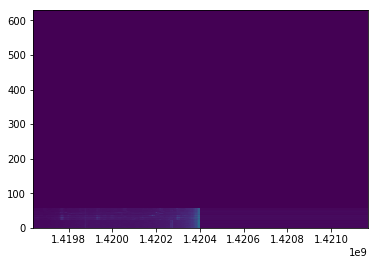

In [31]:
fig, ax = plt.subplots(1)

p = ax.pcolormesh(freqs+freq, np.arange(0, results.shape[0]), results)
plt.show()